## Rapport : Résolution de Problèmes / Machine Learning

#### IMT Mines Alès Octobre 2022
##### INFRES 13 
- **Quentin BIALOTA**
- **Alexandre BOMPUIS**
- **Julia LOCATELLI**
- **Tom L'HERMENIER**

![Logo IMT](https://www.fondation-mines-telecom.org/wp-content/uploads/2018/02/imt_mines_ales-300x158.jpg)

---

Dans le cadre du cours de **ANN & Deep learning** à l'IMT Mines Alès, nous avons dû réalisé un projet de notre choix, visant à résoudre un problème de machine learning, le tout en évaluant et comparant quelques modèles pour la résolution du problème. Pour ce projet, nous avons choisi de traiter une problématique visant à prédire les vêtements que l'on peut observer dans une image donnée. Cette prédiction se fera à partir de différentes caractéristiques, les catégories du vêtement (vêtement, accessoire, etc), et le type d'article.

---

Afin de traiter ce problème, nous avons décidé d'utiliser un dataset déjà existant et disponible sur le site Kaggle. Ce dataset nommé "Fashion Product Images" est accessible au lien suivant : https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

Ce dataset est composé au total d'environ 44000 images de produits trouvés sur le site Zalando et contient dans le dataset original des images de 1440x1080. Pour éviter d'utiliser des images trop lourde, nous utilisons le dataset en version "small", qui a des images au format 80x60 pixels.

![Images Dataset](https://storage.googleapis.com/kaggle-datasets-images/139630/329006/720cd7ceb25eb130d0b873464f734370/dataset-cover.png)

#### Imports globaux

Avant toutes choses, veuillez lancer la cellule suivante pour importer les librairies et les outils utilisés globalement dans ce rapport.

In [88]:
## Import everything needed

from IPython.display import display
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import torch
import torchvision

#### Import du dataset

Via la cellule suivante, vous pouvez importer le dataset en local (le dataset small est disponible [ici](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small?resource=download))

In [89]:
# Import dataset
df = pd.read_csv("fashion-dataset-small/styles.csv", on_bad_lines='skip')

row_to_drop = []
# For every row, test the image path
for i in range(len(df)):
    if not os.path.exists("fashion-dataset-small/images/" + str(df.iloc[i, 0]) + ".jpg"):
        row_to_drop.append(i)

# Drop the rows with bad image path
df = df.drop(row_to_drop)

#### Information sur le dataset

44000+ produits avec des étiquettes de catégorie et des images.

In [92]:
## Dataset visualization

# Show dataset size
display("Dataset size : ", df.shape[0])
# Show the first ten rows of the dataset
display("First ten rows of the dataset", df.head(10))
# Show number of subcategory
display("Number of elements in each subCategory : ", (df.subCategory.value_counts()))
# Show number of articleType in subcategory Topwear
display("Number of articleType in subcategory Topwear :", df[df.subCategory == "Topwear"].articleType.value_counts())

'Dataset size : '

44419

'First ten rows of the dataset'

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


'Number of elements in each subCategory : '

Topwear                     15398
Shoes                        7343
Bags                         3055
Bottomwear                   2693
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care                      77
Skin          

'Number of articleType in subcategory Topwear :'

Tshirts          7065
Shirts           3215
Kurtas           1844
Tops             1762
Sweatshirts       285
Sweaters          277
Jackets           258
Kurtis            234
Tunics            229
Dupatta           116
Suspenders         40
Rain Jacket        18
Waistcoat          15
Rompers            12
Blazers             8
Shrug               6
Nehru Jackets       5
Lehenga Choli       4
Belts               3
Dresses             2
Name: articleType, dtype: int64

##### Exemple d'une image contenu dans le dataset

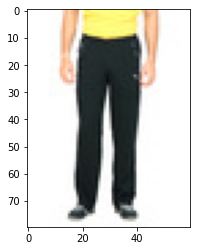

In [59]:
# Show an image of the dataset
image = cv2.imread("fashion-dataset-small/images/18000.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.cvtColor(image, cv2.COLOR_BGR5652GRAY)
plt.imshow(image)
plt.show()

#### Trie du dataset

Le dataset est composé de 10 caractéristiques (id, gender, masterCategory, subCategory, articleType, baseColour, season, year, usage, productDisplayName).

Afin d'effectuer la reconnaissance des vêtements, nous avons dû dans un premier temps sélectionner les catégories de vêtement qu'on allait utiliser plus tard pour entrainer le modèle. 

Notre label sera la colonne articletype. On décide de ne garder que les articles qui compte au moins 200 occurences du même type dans le dataset afin d'avoir assez d'éléments pour entrainer les modèles.

In [93]:
MIN_OCCURRENCE_NUMBER_BY_CLASSES = 200

# Drop subCategory that is not Topwear, Bottomwear, Shoes, Sandal, Bags, Flip Flops, Dress
df = df[df.subCategory.isin(["Topwear", "Bottomwear", "Shoes", "Sandal", "Bags", "Flip Flops", "Dress"])]

# Drop articleType that have less than MIN_OCCURRENCE_NUMBER_BY_CLASSES occurences
df = df[df.groupby('articleType')['articleType'].transform('count').ge(MIN_OCCURRENCE_NUMBER_BY_CLASSES)]

# Show dataset size with Topwear, Bottomwear, Shoes, Sandal, Bags, Flip Flops, Dress
display("New Dataset size : ", df.shape[0])
# Show number of articleType
display("List of articleType in this new dataset :", df['articleType'].unique(), "Size :", len(df['articleType'].unique())) 

'New Dataset size : '

29540

'List of articleType in this new dataset :'

array(['Shirts', 'Jeans', 'Track Pants', 'Tshirts', 'Casual Shoes',
       'Flip Flops', 'Handbags', 'Tops', 'Sandals', 'Sweatshirts',
       'Formal Shoes', 'Flats', 'Kurtas', 'Sports Shoes', 'Shorts',
       'Heels', 'Dresses', 'Clutches', 'Backpacks', 'Trousers', 'Tunics',
       'Jackets', 'Sweaters', 'Kurtis'], dtype=object)

'Size :'

24

Nous avons conservé uniquement les classes qui correspondait à des vêtements qui disposait de plus de 200+ données labélisées, pour arriver à un total de 29540 données labélisées. (Si besoin, il est facile de reparamétrer cette limite de données labélisées minimum)

#### Traitement du dataset (Transformation des labels)

Afin d'avoir la même quantité d'image par type d'article, nous allons augmenter le dataset en faisant des rotations des images déjà présentes.

In [94]:
from torchvision import transforms

transform_imageRand = transforms.Compose([
    # Resize
    transforms.Resize((80, 60))
])

MAX_OCCURRENCE_FOR_INCREASE = 500

def random_rotation(image):
    imageRotate = torchvision.transforms.RandomRotation(90)(image)
    imageRand = transform_imageRand(imageRotate)
    return imageRand

def mirrorHorizontal(image):
    return torchvision.transforms.RandomHorizontalFlip(p=1)(image)

def mirrorVertical(image):
    return torchvision.transforms.RandomVerticalFlip(p=1)(image)

def random_image(image):
    image = random_rotation(image)
    rand = np.random.randint(0, 2)
    if rand == 0:
      image = mirrorHorizontal(image)
    if rand == 1:
      image = mirrorVertical(image)
    if rand == 2:
      image = mirrorHorizontal(image)
      image = mirrorVertical(image)
    return image

from PIL import Image
from torchvision import transforms

transform_imageRand = transforms.Compose([
    # Resize
    transforms.Resize((80, 60))
])

MAX_OCCURRENCE_FOR_INCREASE = 500

def random_rotation(image):
    imageRotate = torchvision.transforms.RandomRotation(90)(image)
    imageRand = transform_imageRand(imageRotate)
    return imageRand

def mirrorHorizontal(image):
    return torchvision.transforms.RandomHorizontalFlip(p=1)(image)

def mirrorVertical(image):
    return torchvision.transforms.RandomVerticalFlip(p=1)(image)

def random_image(image):
    image = random_rotation(image)
    rand = np.random.randint(0, 2)
    if rand == 0:
      image = mirrorHorizontal(image)
    if rand == 1:
      image = mirrorVertical(image)
    if rand == 2:
      image = mirrorHorizontal(image)
      image = mirrorVertical(image)
    return image

def increaseDataset(df, number):

    df2 = df[df.groupby('articleType')['articleType'].transform('count').ge(MAX_OCCURRENCE_FOR_INCREASE)]
    arr1 = df2['articleType'].unique().tolist()
    arr2 = df['articleType'].unique().tolist()

    for element in arr1:
      if element in arr2:
        arr2.remove(element)
    display(arr2)

    subDF = df[df.articleType.isin(arr2)]

    df = pd.DataFrame(columns=['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName'])

    compt = 100000
    for index, row in subDF.iterrows():
      if not os.path.exists("fashion-dataset-small/images/" + str(row['id']) + "_rand.jpg"):
        image = Image.open("fashion-dataset-small/images/" + str(row['id']) + ".jpg")
        for i in range(1, number):
          rand_image = random_image(image)
          rand_image.save("fashion-dataset-small/images/" + str(compt) + "_rand.jpg")
          compt += 1
          df = df.append({'id': compt, 'gender': row['gender'], 'masterCategory': row['masterCategory'], 'subCategory': row['subCategory'], 'articleType': row['articleType'], 'baseColour': row['baseColour'], 'season': row['season'], 'year': row['year'], 'usage': row['usage'], 'productDisplayName': row['productDisplayName']}, ignore_index=True)
    return df

df2 = increaseDataset(df, 2)
df3 = pd.concat([df, df2], ignore_index = True, axis = 0)

display(df.shape[0])
display(df3.shape[0])


['Track Pants',
 'Sweatshirts',
 'Dresses',
 'Clutches',
 'Tunics',
 'Jackets',
 'Sweaters',
 'Kurtis']

29540

31880

Afin de pouvoir traiter ce dataset en tant que problème de classification, nous allons devoir changer le label des classes que nous devons prédire en nombre. (exemple : "Backpacks" => 0, "Shirts" => 1).Afin de pouvoir traiter ce dataset en tant que problème de classification, nous allons devoir changer le label des classes que nous devons prédire en nombre. (exemple : "Backpacks" => 0, "Shirts" => 1).

In [95]:
## Data preprocessing

# For each articleType assign a number
df['articleTypeCode'] = df['articleType'].astype('category')
df['articleTypeCode'] = df['articleTypeCode'].cat.codes

# Get the articleTypeCode and the associated articleType ordered by articleTypeCode
article_type_dict = df[['articleTypeCode', 'articleType']].drop_duplicates().sort_values('articleTypeCode')

# Define the number of classes
CLASSES_NUMBER_OUTPUT = len(article_type_dict)

# Show the articleTypeCode and the associated articleType ordered by articleTypeCode
display("articleTypeCode and the associated articleType", article_type_dict)
# Show number of classes for the output
display("Number of classes : ", CLASSES_NUMBER_OUTPUT)

'articleTypeCode and the associated articleType'

,articleTypeCode,articleType
145,0,Backpacks
10,1,Casual Shoes
135,2,Clutches
94,3,Dresses
34,4,Flats
12,5,Flip Flops
25,6,Formal Shoes
13,7,Handbags
76,8,Heels
257,9,Jackets


'Number of classes : '

24

#### Récupération du device

Afin d'obtenir de meilleures performances lors de l'entrainement et de l'évaluation des différents modèles, nous allons utiliser un GPU à l'aide de cuda si disponible.

In [96]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
print(device)

cuda:0


#### Classe illustrant le dataset

La classe ci-dessous (FashionDataset) permet de manipuler notre dataset en particulier, et notamment de charger les images et leur appliquer des transformation en fonction des modèles utiliser ou bien de les remplacer par des images vides (car certaines images n'existaient pas alors qu'elle était référencé dans le csv).

Le but étant de resortir une image et un label en tant que tensor, afin que pytorch puisse les gérer.

In [97]:
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms

# Create a class for the dataset with colors pictures
class FashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.copy()
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the image if the image exists
        try:
            image = cv2.imread("fashion-dataset-small/images/" + str(self.df.iloc[idx, 0]) + ".jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = np.zeros((80, 60, 3), np.uint8)
        
        # Transform the image
        if self.transform:
            image = self.transform(image)

        # Get the label with the articleType
        label = self.df['articleTypeCode'].iloc[idx]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

#### Transform utilisé pour les différents modèles

In [98]:
transform_lenet5 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [99]:
transform_resnet_18 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [100]:
transform_resnet_50 = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [102]:
transform_alexnet = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [103]:
transform_regnet_y_128gf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(384),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#### Fonction permettant l'enregistrement du model entrainé / le chargement du model entrainé

Ces différentes permettent respectivement d'enregistrer les modèles pendant et après l'entraînement et de les charger à postériori afin de continuer à les entrainer, ou bien de les utiliser pour faire de l'inférence

In [104]:
from pathlib import Path

def save_model_min(model, modelName, path):
    create_directory(modelName)
    torch.save(model.state_dict(), path)

def save_model(model, modelName, epoch, optimizer, path):
    create_directory(modelName)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)

def create_directory(modelName):
    Path("models").mkdir(parents=True, exist_ok=True)
    Path("models/{}".format(modelName)).mkdir(parents=True, exist_ok=True)

def load_model(model, path):
    model.load_state_dict(torch.load(path))

#### Fonction d'entrainement générique

In [105]:
# Print chart after end of training
def printChart(correct_dic, total_dic, rates, lossesValidation, lossesTrain):

  # Show a summary chart of rates %
  plt.plot(np.arange(0, len(rates)), rates)
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.show()

  # Get % of each articleType (classes)
  labelsBars = []
  percentageValues = []

  for article in article_type_dict.values:
    labelsBars.append(article[1])
    percentageValues.append(correct_dic.get(article[0], 0) / total_dic.get(article[0], 1) * 100)
  
  percentage_series = pd.Series(percentageValues)

  # Plot chart of accuracy for each articleType (classes)
  plt.figure(figsize=(12, 8))
  ax = percentage_series.plot(kind="bar")
  ax.set_title("Percentage of accuracy for each articleType of the testing dataset")
  ax.set_ylabel("Percentage of accuracy (%)")
  ax.set_xticklabels(labelsBars)
  plt.show()

  # Plot chart of loss train and loss validation
  plt.plot(np.arange(0, len(lossesValidation)), lossesValidation, color='red', label='Loss validation')
  plt.ylabel("Loss value (avg)")
  plt.plot(np.arange(0, len(lossesTrain)), lossesTrain, color='green', label = 'Loss Train')
  plt.legend(loc = 'upper right')
  plt.show()

In [106]:
import time
import datetime

# Training function
##### INPUTS
# model -> model to be trained
# _train_loader -> Loader for training set
# _test_loader -> Loader for testing set
# epochs -> Number of epochs to perform
# log_frequency -> Log frequency (displays information every x batch)
# device -> Device on which the calculations will be performed
# modelName -> Name of the model (useful for display information and save the model)
# batch_size -> Size of a batch
# learning_rate -> Learning rate (for the optimizer) (default : 1e-4)
# show_items_accuracy -> Display information about Accuracy of EACH item (Shirts, Trousers, ...) (default : True)
# early_stopping -> Enable (or not) Early Stopping in training  (default : False)
# early_stopping_threshold -> Stop when Loss (avg) Train is under Loss (avg) Test - threshold (default : 0.2)
#####

# Training function
def train_optim(model, _train_loader, _test_loader, epochs, log_frequency, device, modelName, batch_size, learning_rate = 1e-4, show_items_accuracy = True, early_stopping = False, early_stopping_threshold = 0.2):

  start_time = time.time()

  print("TRAIN&TEST on {} model | Number of epochs : {} | Batch size : {} | Log frequency : {} | Device : {}".format(modelName, epochs, batch_size, log_frequency, device))

  model.to(device) # we make sure the model is on the proper device

  # Multiclass classification setting, we use cross-entropy
  # note that this implementation requires the logits as input 
  # logits: values prior softmax transformation 
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  numberOfBatch = round(len(_train_loader.dataset) / batch_size)

  rates = []
  lossesValidation = []
  lossesTrain = []
  correct_dic = {}
  total_dic = {}
  for t in range(epochs):

      lossesTrainByBatch = []

      model.train() # we specify that we are training the model

      # At each epoch, the training set will be processed as a set of batches
      for batch_id,  batch in enumerate(_train_loader) : 

        images, labels  = batch

        # we put the data on the same device
        images , labels = images.to(device), labels.to(device)  
        
        y_pred = model(images) # forward pass output=logits

        loss = loss_fn(y_pred, labels)

        lossesTrainByBatch.append(loss.item())

        if batch_id % log_frequency == 0:
          print("Epoch: {:03d} / {} | Batch: {:03d} / {} | Loss: {:.3f} | Time elapsed: {} s ".format(t+1, epochs, batch_id+1, numberOfBatch, loss.item(), str(datetime.timedelta(seconds=(time.time() - start_time)))))

        optimizer.zero_grad() # clear the gradient before backward
        loss.backward()       # update the gradient

        optimizer.step() # update the model parameters using the gradient

      lossesTrain.append((sum(lossesTrainByBatch))/len(lossesTrainByBatch))

      # Model evaluation after each step computing the accuracy
      with torch.no_grad():
        model.eval()
        total = 0
        correct = 0
        lossesValidationByBatch = []

        for batch_id, batch in enumerate(_test_loader):
          images , labels = batch
          
          images , labels = images.to(device), labels.to(device)

          y_pred = model(images) # forward computes the logits

          lossesValidationByBatch.append(loss_fn(y_pred, labels).item())

          sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
          _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
          
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Calculation of the percentage of success of the prediction by classes
          i = 0
          for predict in predicted:
            isCorrect = predict.item() == labels[i].item()
            if(isCorrect):
              if labels[i].item() in correct_dic:
                correct_dic[labels[i].item()] += 1
              else:
                correct_dic[labels[i].item()] = 1
            
            if labels[i].item() in total_dic:
                total_dic[labels[i].item()] += 1
            else:
                total_dic[labels[i].item()] = 1
            i+=1
        
        if(show_items_accuracy):
          for article in article_type_dict.values:
            print("{} => occ:{}/{} | prc:{:.3f}%".format(article[1], correct_dic.get(article[0], 0), total_dic.get(article[0], 1), correct_dic.get(article[0], 0) / total_dic.get(article[0], 1) * 100))
        
        print("[Validation] Accuracy: {:.3f}%".format(100 * correct / total))
        rates.append(correct / total)

        print("[Validation] Loss (avg): {:.3f}\n".format((sum(lossesValidationByBatch))/len(lossesValidationByBatch)))
        lossesValidation.append((sum(lossesValidationByBatch))/len(lossesValidationByBatch))
        
        # Save the model after each epoch
        save_model_min(model, modelName, "models/{}/{}_{}.pt".format(modelName, modelName, t))

        if(early_stopping):
          if(lossesTrain[len(lossesTrain) - 1] <= lossesValidation[len(lossesValidation) - 1] - early_stopping_threshold):
            printChart(correct_dic, total_dic, rates, lossesValidation, lossesTrain)
            return

  printChart(correct_dic, total_dic, rates, lossesValidation, lossesTrain)

#### Fonctions de Freeze et d'Unfreeze de modèles

Fonctions utilisées pour les modèles pré-entrainés, elles perementtent respectivement de :
- Freeze un modèle => On bloque la mise à jour des paramètres (pas de calcul des gradients)
- Unfreeze un modèle => On débloque la mise à jour des paramètres (mode "normal")

In [107]:
from torchvision import models

def freeze_model(model):
  for param in model.parameters():
    param.requires_grad = False

def unfreeze_model(model):
  for param in model.parameters():
    param.requires_grad = True

Liste des modèles dans PyTorch :

In [83]:
help(models)

Help on package torchvision.models in torchvision:

NAME
    torchvision.models

PACKAGE CONTENTS
    _api
    _meta
    _utils
    alexnet
    convnext
    densenet
    detection (package)
    efficientnet
    feature_extraction
    googlenet
    inception
    mnasnet
    mobilenet
    mobilenetv2
    mobilenetv3
    optical_flow (package)
    quantization (package)
    regnet
    resnet
    segmentation (package)
    shufflenetv2
    squeezenet
    swin_transformer
    vgg
    video (package)
    vision_transformer

FILE
    c:\users\quent\appdata\local\programs\python\python310\lib\site-packages\torchvision\models\__init__.py




In [108]:
def make_a_prediction(image_path, model, device, transform):

    # Show an image of the dataset
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR5652GRAY)
    plt.imshow(image)
    plt.show()

    tensor_image = transform(image)

    # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
    tensor_image_unsqueeze = torch.unsqueeze(tensor_image, 0)
    tensor_image_unsqueeze = tensor_image_unsqueeze.to(device)

    model.eval()

    logits = model(tensor_image_unsqueeze) # pass forward
    distrib_prob = torch.nn.Softmax(dim=1)(logits)
    proba, predicted = torch.topk(distrib_prob, 5, 1) # decision rule, we select the max
    
    proba_list = proba.tolist()[0]
    i = 0
    for predict in predicted.tolist()[0]:
        print("{} => {:.3}%".format(article_type_dict.loc[article_type_dict.articleTypeCode == predict].values[0][1], proba_list[i] * 100))
        i += 1


#### **Model LeNet5**

##### Architecture :

![letnet-5-architecture](https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg)

*(source : https://www.datasciencecentral.com/lenet-5-a-classic-cnn-architecture/)*

In [109]:
##A titre d'exemple

##########################################
MODEL_NAME = "LeNet5"
ETA = 1e-4 # Learning rate
EPOCHS = 10 # Epochs / Number of iteration
LOGS = 200 # Log Frequency
BATCH_SIZE = 32 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
###########################################################################################

### LE NET 5
class LeNet5(torch.nn.Module):

  def __init__(self, D_out):

    super(LeNet5, self).__init__()
    self.name = "LeNet5"

    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(32,32), stride=1, padding=2)
    self.avgPool1 = torch.nn.AvgPool2d(kernel_size=(2,2), stride=2)
    self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(2,2), stride=1)
    self.avgPool2 = torch.nn.AvgPool2d(kernel_size=(1,1), stride=2)
    self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1,1), stride=1) 
    self.flatten = torch.nn.Flatten()

    self.linear1 = torch.nn.Linear(64, 84)
    self.linear2 = torch.nn.Linear(84, 42)
    self.linear3 = torch.nn.Linear(42, 21)
    self.linear4 = torch.nn.Linear(21, D_out)
  
  def forward(self, x):
      
    x = torch.nn.functional.relu(self.conv1(x)) 
    x = self.avgPool1(x)
    x = torch.nn.functional.relu(self.conv2(x))
    x = self.avgPool2(x)
    x = torch.nn.functional.relu(self.conv3(x))
    x = self.flatten(x)
    x = torch.nn.functional.relu(self.linear1(x))
    x = torch.nn.functional.relu(self.linear2(x))
    x = torch.nn.functional.relu(self.linear3(x))
    x = self.linear4(x)
    
    return x

dataset_lenet5 = FashionDataset(df, transform=transform_lenet5)

train_size_lenet5 = int(0.8 * len(dataset_lenet5))
test_size_lenet5 = len(dataset_lenet5) - train_size_lenet5
train_dataset_lenet5, test_dataset_lenet5 = random_split(dataset_lenet5, [train_size_lenet5, test_size_lenet5])
train_loader_lenet5 = DataLoader(train_dataset_lenet5, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lenet5 = DataLoader(test_dataset_lenet5, batch_size=BATCH_SIZE, shuffle=True)

model_lenet5 = LeNet5(CLASSES_NUMBER_OUTPUT)

In [110]:
### LENET 5 TRAIN
train_optim(model_lenet5, train_loader_lenet5, test_loader_lenet5, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA, False)

TRAIN&TEST on LeNet5 model | Number of epochs : 10 | Batch size : 32 | Log frequency : 200 | Device : cuda:0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 64x84)

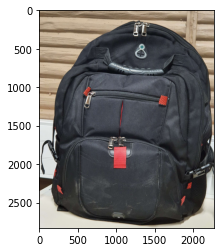

Shirts => 9.97%
Jackets => 9.36%
Sweatshirts => 7.32%
Jeans => 6.8%
Sweaters => 6.25%


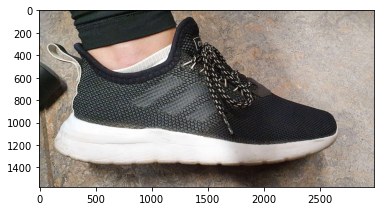

Casual Shoes => 41.6%
Sports Shoes => 40.3%
Formal Shoes => 10.1%
Sandals => 3.05%
Flip Flops => 2.09%


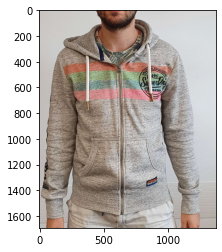

Tshirts => 30.9%
Shirts => 30.2%
Sweaters => 7.54%
Jackets => 6.98%
Sweatshirts => 6.76%


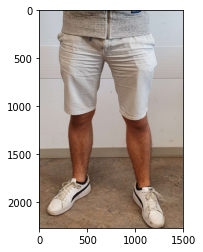

Flip Flops => 13.2%
Jackets => 12.8%
Sweaters => 9.67%
Shirts => 9.57%
Sweatshirts => 8.09%


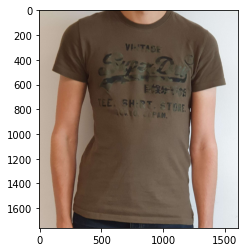

Tshirts => 78.3%
Shirts => 14.1%
Tops => 2.19%
Casual Shoes => 1.99%
Sweatshirts => 0.916%


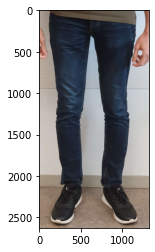

Shirts => 9.08%
Jeans => 7.31%
Sweatshirts => 6.49%
Jackets => 6.18%
Sweaters => 6.1%


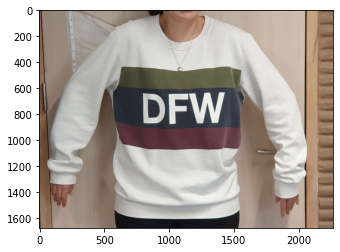

Tshirts => 60.6%
Casual Shoes => 14.2%
Sports Shoes => 4.97%
Shirts => 3.24%
Jackets => 3.15%


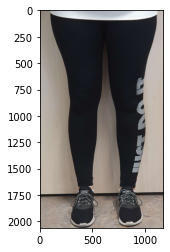

Shirts => 27.3%
Tshirts => 14.8%
Tops => 11.3%
Sweatshirts => 8.55%
Sweaters => 7.06%


In [71]:
### LENET 5 INFERENCE

#model_lenet5 = LeNet5(CLASSES_NUMBER_OUTPUT)
#load_model(model_lenet5, "models/LeNet5/LeNet5_9.pt")

make_a_prediction("testing-images/20221007_112132.jpg", model_lenet5, device, transform_lenet5)
make_a_prediction("testing-images/20221007_111900.jpg", model_lenet5, device, transform_lenet5)

make_a_prediction("testing-images/haut-tom.jpg", model_lenet5, device, transform_lenet5)
make_a_prediction("testing-images/bas_tom.jpg", model_lenet5, device, transform_lenet5)
make_a_prediction("testing-images/haut-alexandre.jpg", model_lenet5, device, transform_lenet5)
make_a_prediction("testing-images/bas-alexandre.jpg", model_lenet5, device, transform_lenet5)
make_a_prediction("testing-images/haut-julia.jpg", model_lenet5, device, transform_lenet5)
make_a_prediction("testing-images/bas-julia.jpg", model_lenet5, device, transform_lenet5)

In [ ]:
dataset_lenet5 = FashionDataset(df3, transform=transform_lenet5)

train_size_lenet5 = int(0.8 * len(dataset_lenet5))
test_size_lenet5 = len(dataset_lenet5) - train_size_lenet5
train_dataset_lenet5, test_dataset_lenet5 = random_split(dataset_lenet5, [train_size_lenet5, test_size_lenet5])
train_loader_lenet5 = DataLoader(train_dataset_lenet5, batch_size=BATCH_SIZE, shuffle=True)
test_loader_lenet5 = DataLoader(test_dataset_lenet5, batch_size=BATCH_SIZE, shuffle=True)

model_lenet5 = LeNet5(CLASSES_NUMBER_OUTPUT)

### LENET 5 TRAIN
train_optim(model_lenet5, train_loader_lenet5, test_loader_lenet5, EPOCHS, LOGS, device, "{}_newDataset".format(MODEL_NAME), BATCH_SIZE, ETA, False)

On peut ainsi remarquer avec les résultats que le modèle "lenet5" n'est pas très efficace pour traiter notre problématique de détection de vêtement

#### **Modèle : ResNet18**

Au vu des résultats du modèle précédent, nous avons fait le choix d'utiliser un modèle qui a plus fait ces preuves, que l'on a pu utiliser lors des séances de TP.

##### Architecture :

![resnet-18-architecture](https://penseeartificielle.fr/wp-content/uploads/2019/01/Proposed-Modified-ResNet-18-architecture-for-Bangla-HCR-In-the-diagram-conv-stands-for.jpg)

*(source : https://penseeartificielle.fr/focus-reseau-neurones-convolutifs/proposed-modified-resnet-18-architecture-for-bangla-hcr-in-the-diagram-conv-stands-for/)*

In [47]:
##########################################
MODEL_NAME = "ResNet18"
ETA = 1e-4 # Learning rate
EPOCHS = 10 # Epochs / Number of iteration
LOGS = 200 # Log Frequency
BATCH_SIZE = 16 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
###########################################################################################

### RESNET 18 PRETRAINED

resnet18 = models.resnet18()
resnet18_pretrained = models.resnet18(weights="ResNet18_Weights.DEFAULT") # Best available weights (currently alias for IMAGENET1K_V1)
resnet18_pretrained_freezed = models.resnet18(weights="ResNet18_Weights.DEFAULT") # Best available weights (currently alias for IMAGENET1K_V1)

freeze_model(resnet18_pretrained_freezed)

dataset_resnet18 = FashionDataset(df, transform=transform_resnet_18)

train_size_resnet18 = int(0.8 * len(dataset_resnet18))
test_size_resnet18 = len(dataset_resnet18) - train_size_resnet18
train_dataset_resnet18, test_dataset_resnet18 = random_split(dataset_resnet18, [train_size_resnet18, test_size_resnet18])
train_loader_resnet18 = DataLoader(train_dataset_resnet18, batch_size=BATCH_SIZE, shuffle=True)
test_loader_resnet18 = DataLoader(test_dataset_resnet18, batch_size=BATCH_SIZE, shuffle=True)

resnet18.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)
resnet18_pretrained.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)
resnet18_pretrained_freezed.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)

TRAIN&TEST on ResNet18 model | Number of epochs : 10 | Batch size : 16 | Log frequency : 200 | Device : cuda:0
Epoch: 001 / 10 | Batch: 001 / 1477 | Loss: 3.080 | Time elapsed: 0:00:06.476398 s 
Epoch: 001 / 10 | Batch: 201 / 1477 | Loss: 1.524 | Time elapsed: 0:00:21.572605 s 
Epoch: 001 / 10 | Batch: 401 / 1477 | Loss: 1.661 | Time elapsed: 0:00:39.140676 s 
Epoch: 001 / 10 | Batch: 601 / 1477 | Loss: 1.524 | Time elapsed: 0:00:57.583570 s 
Epoch: 001 / 10 | Batch: 801 / 1477 | Loss: 0.750 | Time elapsed: 0:01:16.975269 s 
Epoch: 001 / 10 | Batch: 1001 / 1477 | Loss: 1.215 | Time elapsed: 0:01:36.526177 s 
Epoch: 001 / 10 | Batch: 1201 / 1477 | Loss: 1.010 | Time elapsed: 0:01:56.546152 s 
Epoch: 001 / 10 | Batch: 1401 / 1477 | Loss: 1.342 | Time elapsed: 0:02:17.285662 s 
[Validation] Accuracy: 73.020%
[Validation] Loss (avg): 0.753

Epoch: 002 / 10 | Batch: 001 / 1477 | Loss: 1.065 | Time elapsed: 0:02:54.557878 s 
Epoch: 002 / 10 | Batch: 201 / 1477 | Loss: 0.529 | Time elapsed: 0

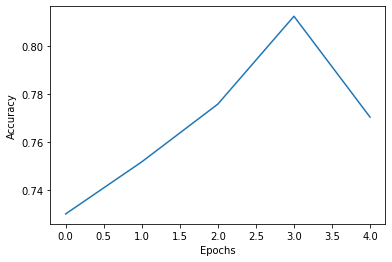

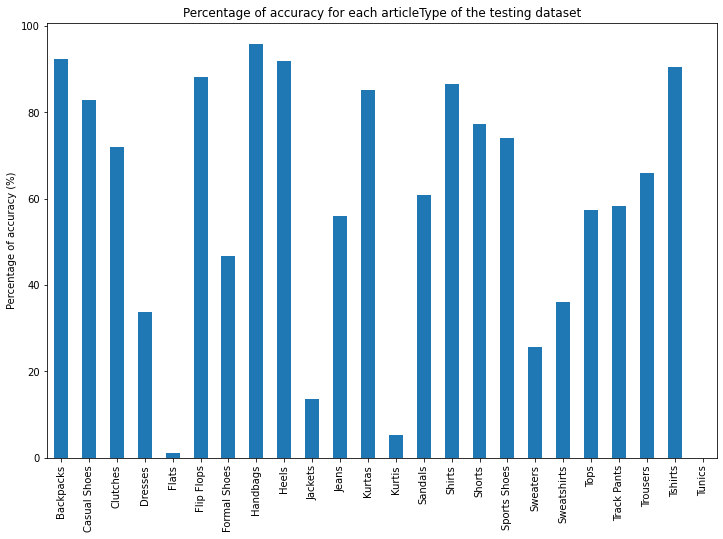

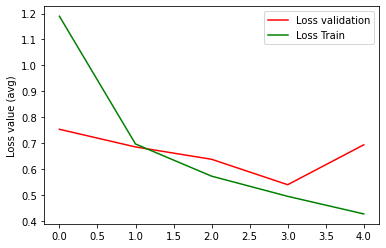

In [48]:
### RESNET 18 TRAIN
train_optim(resnet18, train_loader_resnet18, test_loader_resnet18, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA, False)

#NOTE : If you want to use early_stopping :
# train_optim(resnet18, train_loader_resnet18, test_loader_resnet18, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA, False, True, 0.2) #The last value is the Threshold

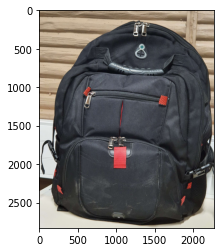

Backpacks => 51.7%
Jackets => 15.8%
Sweatshirts => 11.7%
Handbags => 7.78%
Shirts => 6.45%


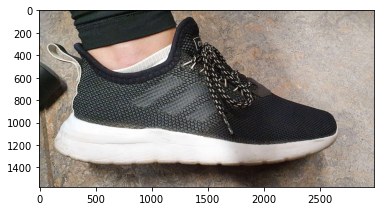

Tshirts => 63.9%
Handbags => 21.8%
Tops => 6.97%
Shirts => 3.96%
Jackets => 1.67%


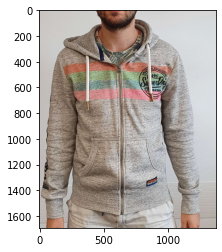

Shirts => 82.4%
Shorts => 7.11%
Tops => 3.31%
Handbags => 1.78%
Jackets => 1.63%


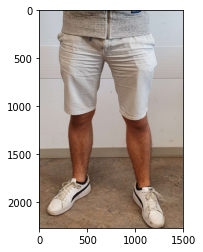

Tops => 50.8%
Tshirts => 20.5%
Dresses => 6.02%
Flip Flops => 5.19%
Sandals => 2.69%


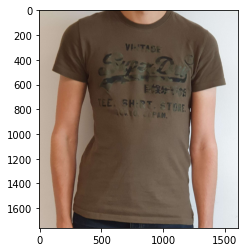

Tshirts => 99.1%
Shirts => 0.345%
Tops => 0.296%
Kurtas => 0.0728%
Jackets => 0.0449%


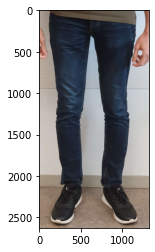

Track Pants => 54.9%
Trousers => 13.3%
Heels => 10.3%
Shorts => 5.98%
Flats => 5.0%


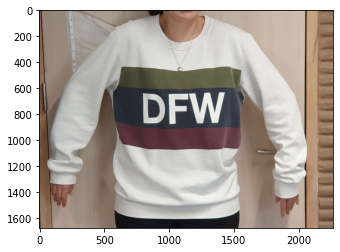

Tshirts => 95.3%
Tops => 2.36%
Sweaters => 0.525%
Jackets => 0.368%
Sweatshirts => 0.361%


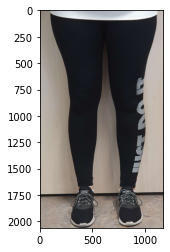

Shorts => 34.2%
Track Pants => 26.1%
Trousers => 18.3%
Jeans => 5.62%
Tshirts => 4.86%


In [49]:
### RESNET 18 INFERENCE

#resnet18 = models.resnet18()
#resnet18.fc = torch.nn.Sequential(
#    torch.nn.Linear(512, 256),
#    torch.nn.ReLU(),
#    torch.nn.Linear(256, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
#)
#resnet18.to(device)
#load_model(resnet18, "models/ResNet18/ResNet18_9.pt")

make_a_prediction("testing-images/20221007_112132.jpg", resnet18, device, transform_resnet_18)
make_a_prediction("testing-images/20221007_111900.jpg", resnet18, device, transform_resnet_18)

make_a_prediction("testing-images/haut-tom.jpg", resnet18, device, transform_resnet_18)
make_a_prediction("testing-images/bas_tom.jpg", resnet18, device, transform_resnet_18)
make_a_prediction("testing-images/haut-alexandre.jpg", resnet18, device, transform_resnet_18)
make_a_prediction("testing-images/bas-alexandre.jpg", resnet18, device, transform_resnet_18)
make_a_prediction("testing-images/haut-julia.jpg", resnet18, device, transform_resnet_18)
make_a_prediction("testing-images/bas-julia.jpg", resnet18, device, transform_resnet_18)

In [ ]:
### RESNET 18 PRETRAINED INFERENCE (Not Freeze)

#resnet18_pretrained_freezed = models.resnet18()
#resnet18_pretrained_freezed.fc = torch.nn.Sequential(
#    torch.nn.Linear(512, 256),
#    torch.nn.ReLU(),
#    torch.nn.Linear(256, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
#)
#resnet18_pretrained_freezed.to(device)
#load_model(resnet18_pretrained_freezed, "models/ResNet18_pretrained/ResNet18_pretrained_freezed_9.pt")

make_a_prediction("testing-images/20221007_112132.jpg", resnet18_pretrained, device, transform_resnet_18)
make_a_prediction("testing-images/20221007_111900.jpg", resnet18_pretrained, device, transform_resnet_18)

make_a_prediction("testing-images/haut-tom.jpg", resnet18_pretrained, device, transform_resnet_18)
make_a_prediction("testing-images/bas_tom.jpg", resnet18_pretrained, device, transform_resnet_18)
make_a_prediction("testing-images/haut-alexandre.jpg", resnet18_pretrained, device, transform_resnet_18)
make_a_prediction("testing-images/bas-alexandre.jpg", resnet18_pretrained, device, transform_resnet_18)
make_a_prediction("testing-images/haut-julia.jpg", resnet18_pretrained, device, transform_resnet_18)
make_a_prediction("testing-images/bas-julia.jpg", resnet18_pretrained, device, transform_resnet_18)

In [ ]:
### RESNET 18 PRETRAINED TRAIN (Freezed)
train_optim(resnet18_pretrained_freezed, train_loader_resnet18, test_loader_resnet18, EPOCHS, LOGS, device, "{}_pretrained_freezed".format(MODEL_NAME), BATCH_SIZE, ETA, False)

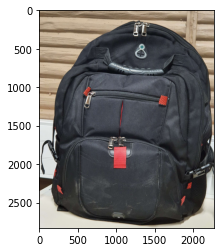

Backpacks => 92.8%
Shorts => 5.22%
Jeans => 0.929%
Track Pants => 0.479%
Jackets => 0.292%


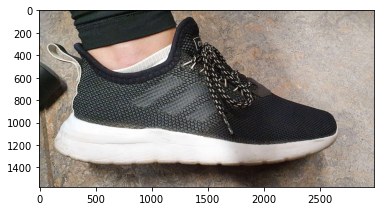

Casual Shoes => 48.2%
Jeans => 25.0%
Track Pants => 7.2%
Sandals => 6.76%
Sports Shoes => 6.36%


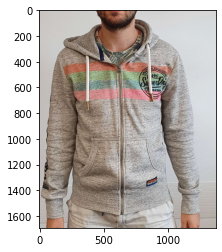

Jeans => 41.4%
Tshirts => 31.7%
Track Pants => 9.17%
Trousers => 7.18%
Tops => 6.01%


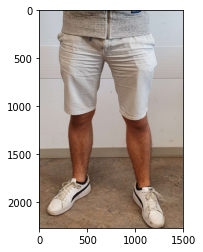

Shorts => 98.6%
Track Pants => 0.67%
Casual Shoes => 0.287%
Jeans => 0.206%
Sports Shoes => 0.0981%


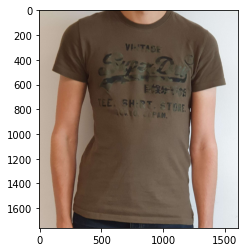

Tshirts => 99.4%
Tops => 0.55%
Flip Flops => 0.0501%
Shorts => 0.00973%
Dresses => 0.0049%


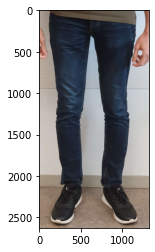

Jeans => 99.3%
Track Pants => 0.59%
Casual Shoes => 0.0549%
Flip Flops => 0.0315%
Dresses => 0.0109%


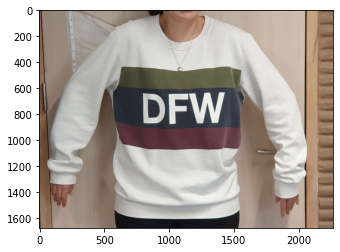

Tshirts => 73.4%
Jeans => 15.3%
Tops => 4.93%
Track Pants => 3.2%
Dresses => 1.29%


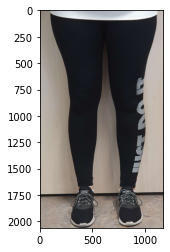

Flip Flops => 79.8%
Jeans => 10.4%
Track Pants => 7.92%
Casual Shoes => 0.579%
Shorts => 0.436%


In [37]:
### RESNET 18 PRETRAINED INFERENCE (Freezed)

#resnet18_pretrained_freezed = models.resnet18()
#resnet18_pretrained_freezed.fc = torch.nn.Sequential(
#    torch.nn.Linear(512, 256),
#    torch.nn.ReLU(),
#    torch.nn.Linear(256, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
#)
#resnet18_pretrained_freezed.to(device)
#load_model(resnet18_pretrained_freezed, "models/ResNet18_pretrained_freezed/ResNet18_pretrained_9.pt")

make_a_prediction("testing-images/20221007_112132.jpg", resnet18_pretrained_freezed, device, transform_resnet_18)
make_a_prediction("testing-images/20221007_111900.jpg", resnet18_pretrained_freezed, device, transform_resnet_18)

make_a_prediction("testing-images/haut-tom.jpg", resnet18_pretrained_freezed, device, transform_resnet_18)
make_a_prediction("testing-images/bas_tom.jpg", resnet18_pretrained_freezed, device, transform_resnet_18)
make_a_prediction("testing-images/haut-alexandre.jpg", resnet18_pretrained_freezed, device, transform_resnet_18)
make_a_prediction("testing-images/bas-alexandre.jpg", resnet18_pretrained_freezed, device, transform_resnet_18)
make_a_prediction("testing-images/haut-julia.jpg", resnet18_pretrained_freezed, device, transform_resnet_18)
make_a_prediction("testing-images/bas-julia.jpg", resnet18_pretrained_freezed, device, transform_resnet_18)

Cette fois-ci, on peut que remarquer que les résultats sont bien plus convenables et que l'on rencontre moins d'abération lors de la prédiction. Néanmoins, ce modèle n'est toujours pas parfait (+- 82-83% de précision).

#### **Model ResNet50**

Nous avons ensuite choisi d'utiliser le modèle "resnet50" afin de voir si les résultats seront meilleurs que son prédécésseur.

##### Architecture :

![resnet-50-architecture](https://miro.medium.com/max/828/0*9LqUp7XyEx1QNc6A.png)

*(source : https://blog.devgenius.io/resnet50-6b42934db431)*

TRAIN&TEST on ResNet50_pretrained model | Number of epochs : 7 | Batch size : 16 | Log frequency : 200 | Device : cuda:0
Epoch: 001 / 7 | Batch: 001 / 1477 | Loss: 3.212 | Time elapsed: 0:00:00.526302 s 
Epoch: 001 / 7 | Batch: 201 / 1477 | Loss: 0.864 | Time elapsed: 0:00:46.490425 s 
Epoch: 001 / 7 | Batch: 401 / 1477 | Loss: 1.085 | Time elapsed: 0:01:32.429201 s 
Epoch: 001 / 7 | Batch: 601 / 1477 | Loss: 0.332 | Time elapsed: 0:02:18.579148 s 
Epoch: 001 / 7 | Batch: 801 / 1477 | Loss: 0.548 | Time elapsed: 0:03:05.332336 s 
Epoch: 001 / 7 | Batch: 1001 / 1477 | Loss: 0.479 | Time elapsed: 0:03:52.620630 s 
Epoch: 001 / 7 | Batch: 1201 / 1477 | Loss: 0.655 | Time elapsed: 0:04:40.468129 s 
Epoch: 001 / 7 | Batch: 1401 / 1477 | Loss: 0.217 | Time elapsed: 0:05:27.378903 s 
[Validation] Accuracy: 85.816%
[Validation] Loss (avg): 0.411

Epoch: 002 / 7 | Batch: 001 / 1477 | Loss: 0.695 | Time elapsed: 0:06:18.399567 s 
Epoch: 002 / 7 | Batch: 201 / 1477 | Loss: 0.210 | Time elapsed: 0

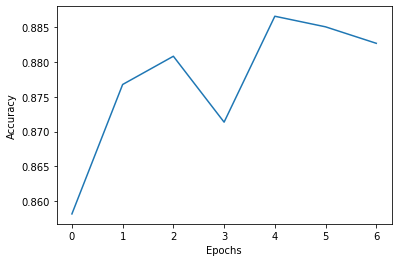

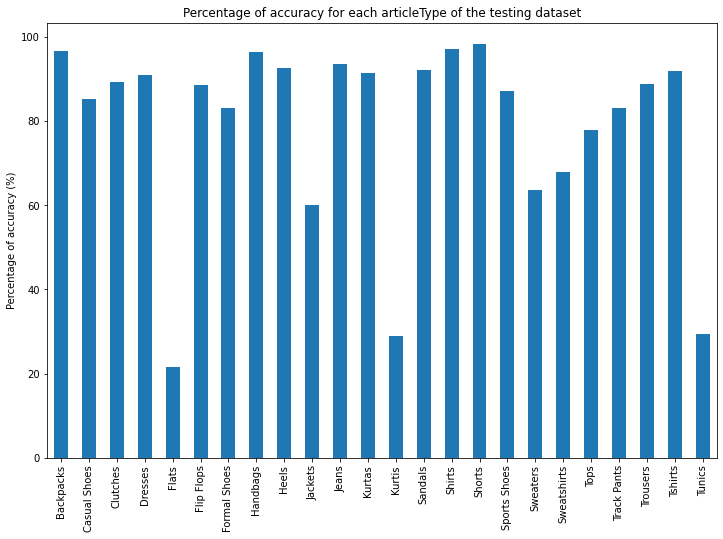

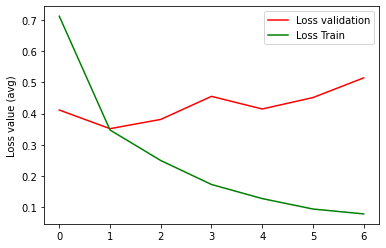

In [57]:
##########################################
MODEL_NAME = "ResNet50"
ETA = 1e-4 # Learning rate
EPOCHS = 7 # Epochs / Number of iteration
LOGS = 200 # Log Frequency
BATCH_SIZE = 16 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
###########################################################################################

### RESNET 50
resnet50 = models.resnet50()
resnet50_pretained = models.resnet50(weights="ResNet50_Weights.DEFAULT") # Best available weights (currently alias for IMAGENET1K_V2)
resnet50_pretained_freezed = models.resnet50(weights="ResNet50_Weights.DEFAULT") # Best available weights (currently alias for IMAGENET1K_V2)

freeze_model(resnet50_pretained_freezed)

dataset_resnet50 = FashionDataset(df, transform=transform_resnet_50)

train_size_resnet50 = int(0.8 * len(dataset_resnet50))
test_size_resnet50 = len(dataset_resnet50) - train_size_resnet50
train_dataset_resnet50, test_dataset_resnet50 = random_split(dataset_resnet50, [train_size_resnet50, test_size_resnet50])
train_loader_resnet50 = DataLoader(train_dataset_resnet50, batch_size=BATCH_SIZE, shuffle=True)
test_loader_resnet50 = DataLoader(test_dataset_resnet50, batch_size=BATCH_SIZE, shuffle=True)

resnet50.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)
resnet50_pretained.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)
resnet50_pretained_freezed.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)

In [ ]:
### RESNET 50 TRAIN
train_optim(resnet50, train_loader_resnet50, test_loader_resnet50, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA, True)

In [ ]:
### RESNET 50 INFERENCE

#resnet50 = models.resnet50()
#resnet50.fc = torch.nn.Sequential(
#    torch.nn.Linear(2048, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 512),
#    torch.nn.ReLU(),
#    torch.nn.Linear(512, 256),
#    torch.nn.ReLU(),
#    torch.nn.Linear(256, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
#)
#resnet50.to(device)
#load_model(resnet50, "models/ResNet50/ResNet50_6.pt")

make_a_prediction("testing-images/20221007_112132.jpg", resnet50, device, transform_resnet_50)
make_a_prediction("testing-images/20221007_111900.jpg", resnet50, device, transform_resnet_50)

make_a_prediction("testing-images/haut-tom.jpg", resnet50, device, transform_resnet_50)
make_a_prediction("testing-images/bas_tom.jpg", resnet50, device, transform_resnet_50)
make_a_prediction("testing-images/haut-alexandre.jpg", resnet50, device, transform_resnet_50)
make_a_prediction("testing-images/bas-alexandre.jpg", resnet50, device, transform_resnet_50)
make_a_prediction("testing-images/haut-julia.jpg", resnet50, device, transform_resnet_50)
make_a_prediction("testing-images/bas-julia.jpg", resnet50, device, transform_resnet_50)

In [ ]:
### RESNET 50 PRETRAINED TRAIN (Not Freeze)
train_optim(resnet50_pretained, train_loader_resnet50, test_loader_resnet50, EPOCHS, LOGS, device, "{}_pretrained".format(MODEL_NAME), BATCH_SIZE, ETA, True)

In [ ]:
### RESNET 50 PRETRAINED INFERENCE (Not Freeze)

#resnet50_pretained = models.resnet50()
#resnet50_pretained.fc = torch.nn.Sequential(
#    torch.nn.Linear(2048, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 512),
#    torch.nn.ReLU(),
#    torch.nn.Linear(512, 256),
#    torch.nn.ReLU(),
#    torch.nn.Linear(256, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
#)
#resnet50_pretained.to(device)
#load_model(resnet50_pretained, "models/ResNet50_pretained/ResNet50_pretained_6.pt")

make_a_prediction("testing-images/20221007_112132.jpg", resnet50_pretained, device, transform_resnet_50)
make_a_prediction("testing-images/20221007_111900.jpg", resnet50_pretained, device, transform_resnet_50)

make_a_prediction("testing-images/haut-tom.jpg", resnet50_pretained, device, transform_resnet_50)
make_a_prediction("testing-images/bas_tom.jpg", resnet50_pretained, device, transform_resnet_50)
make_a_prediction("testing-images/haut-alexandre.jpg", resnet50_pretained, device, transform_resnet_50)
make_a_prediction("testing-images/bas-alexandre.jpg", resnet50_pretained, device, transform_resnet_50)
make_a_prediction("testing-images/haut-julia.jpg", resnet50_pretained, device, transform_resnet_50)
make_a_prediction("testing-images/bas-julia.jpg", resnet50_pretained, device, transform_resnet_50)

In [ ]:
### RESNET 50 PRETRAINED TRAIN (Freezed)
train_optim(resnet50_pretained_freezed, train_loader_resnet50, test_loader_resnet50, EPOCHS, LOGS, device, "{}_pretrained_freezed".format(MODEL_NAME), BATCH_SIZE, ETA, True)

In [ ]:
### RESNET 50 PRETRAINED INFERENCE (Freezed)

#resnet50_pretained_freezed = models.resnet50()
#resnet50_pretained_freezed.fc = torch.nn.Sequential(
#    torch.nn.Linear(2048, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 512),
#    torch.nn.ReLU(),
#    torch.nn.Linear(512, 256),
#    torch.nn.ReLU(),
#    torch.nn.Linear(256, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
#)
#resnet50_pretained_freezed.to(device)
#load_model(resnet50_pretained_freezed, "models/ResNet50_pretrained_freezed/ResNet50_pretrained_freezed_6.pt")

make_a_prediction("testing-images/20221007_112132.jpg", resnet50_pretained_freezed, device, transform_resnet_50)
make_a_prediction("testing-images/20221007_111900.jpg", resnet50_pretained_freezed, device, transform_resnet_50)

make_a_prediction("testing-images/haut-tom.jpg", resnet50_pretained_freezed, device, transform_resnet_50)
make_a_prediction("testing-images/bas_tom.jpg", resnet50_pretained_freezed, device, transform_resnet_50)
make_a_prediction("testing-images/haut-alexandre.jpg", resnet50_pretained_freezed, device, transform_resnet_50)
make_a_prediction("testing-images/bas-alexandre.jpg", resnet50_pretained_freezed, device, transform_resnet_50)
make_a_prediction("testing-images/haut-julia.jpg", resnet50_pretained_freezed, device, transform_resnet_50)
make_a_prediction("testing-images/bas-julia.jpg", resnet50_pretained_freezed, device, transform_resnet_50)

#### **Model AlexNet**

##### Architecture :

![alexnet-architecture](https://raw.githubusercontent.com/blurred-machine/Data-Science/master/Deep%20Learning%20SOTA/img/alexnet2.png)

*(source : https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide/notebook)*

TRAIN&TEST on AlexNet model | Number of epochs : 7 | Batch size : 16 | Log frequency : 200 | Device : cuda:0
Epoch: 001 / 7 | Batch: 001 / 1477 | Loss: 3.180 | Time elapsed: 0:00:00.354465 s 
Epoch: 001 / 7 | Batch: 201 / 1477 | Loss: 1.093 | Time elapsed: 0:00:09.702925 s 
Epoch: 001 / 7 | Batch: 401 / 1477 | Loss: 0.934 | Time elapsed: 0:00:18.877118 s 
Epoch: 001 / 7 | Batch: 601 / 1477 | Loss: 1.414 | Time elapsed: 0:00:28.947271 s 
Epoch: 001 / 7 | Batch: 801 / 1477 | Loss: 0.814 | Time elapsed: 0:00:39.699754 s 
Epoch: 001 / 7 | Batch: 1001 / 1477 | Loss: 1.199 | Time elapsed: 0:00:51.268462 s 
Epoch: 001 / 7 | Batch: 1201 / 1477 | Loss: 0.668 | Time elapsed: 0:01:02.885099 s 
Epoch: 001 / 7 | Batch: 1401 / 1477 | Loss: 0.300 | Time elapsed: 0:01:14.823867 s 
Backpacks => occ:130/137 | prc:94.891%
Casual Shoes => occ:426/584 | prc:72.945%
Clutches => occ:45/61 | prc:73.770%
Dresses => occ:1/88 | prc:1.136%
Flats => occ:0/96 | prc:0.000%
Flip Flops => occ:135/183 | prc:73.770%
For

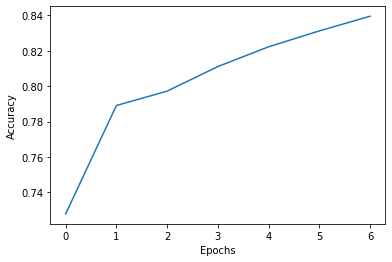

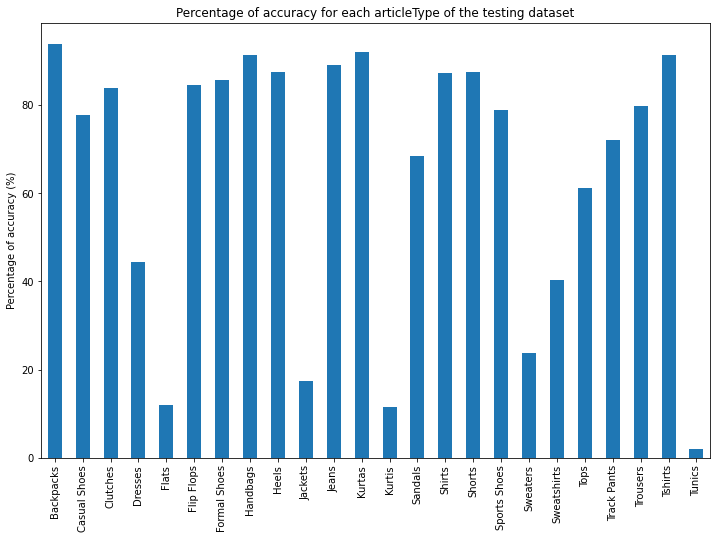

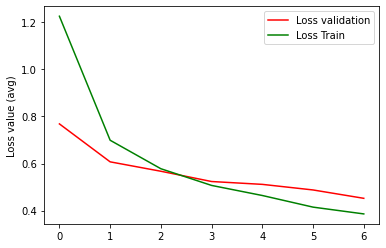

In [58]:
##########################################
MODEL_NAME = "AlexNet"
ETA = 1e-4 # Learning rate
EPOCHS = 7 # Epochs / Number of iteration
LOGS = 200 # Log Frequency
BATCH_SIZE = 16 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
###########################################################################################

### AlexNet
alexnet = models.alexnet()
alexnet_pretrained = models.alexnet(weights="AlexNet_Weights.DEFAULT") # Best available weights (currently alias for IMAGENET1K_V1)
alexnet_pretrained_freezed = models.alexnet(weights="AlexNet_Weights.DEFAULT") # Best available weights (currently alias for IMAGENET1K_V1)

freeze_model(alexnet_pretrained_freezed)

dataset_alexnet = FashionDataset(df, transform=transform_alexnet)

train_size_alexnet = int(0.8 * len(dataset_alexnet))
test_size_alexnet = len(dataset_alexnet) - train_size_alexnet
train_dataset_alexnet, test_dataset_alexnet = random_split(dataset_alexnet, [train_size_alexnet, test_size_alexnet])
train_loader_alexnet = DataLoader(train_dataset_alexnet, batch_size=16, shuffle=True)
test_loader_alexnet = DataLoader(test_dataset_alexnet, batch_size=16, shuffle=True)

# Change on alexnet model to fit our dataset
alexnet.features = torch.nn.Sequential(*list(alexnet.features.children())[:-1])
alexnet.classifier[6] = torch.nn.Linear(4096, CLASSES_NUMBER_OUTPUT)

# Change on alexnet_pretrained model to fit our dataset
alexnet_pretrained.features = torch.nn.Sequential(*list(alexnet.features.children())[:-1])
alexnet_pretrained.classifier[6] = torch.nn.Linear(4096, CLASSES_NUMBER_OUTPUT)

# Change on alexnet_pretrained_freezed model to fit our dataset
alexnet_pretrained_freezed.features = torch.nn.Sequential(*list(alexnet.features.children())[:-1])
alexnet_pretrained_freezed.classifier[6] = torch.nn.Linear(4096, CLASSES_NUMBER_OUTPUT)

In [ ]:
### ALEXNET TRAIN
train_optim(alexnet, train_loader_alexnet, test_loader_alexnet, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA, False)

In [ ]:
### ALEXNET INFERENCE

#alexnet = models.alexnet()
#alexnet.features = torch.nn.Sequential(*list(alexnet.features.children())[:-1])
#alexnet.classifier[6] = torch.nn.Linear(4096, CLASSES_NUMBER_OUTPUT)
#load_model(alexnet, "models/AlexNet/AlexNet_6.pt")

make_a_prediction("testing-images/20221007_112132.jpg", alexnet, device, transform_alexnet)
make_a_prediction("testing-images/20221007_111900.jpg", alexnet, device, transform_alexnet)

make_a_prediction("testing-images/haut-tom.jpg", alexnet, device, transform_alexnet)
make_a_prediction("testing-images/bas_tom.jpg", alexnet, device, transform_alexnet)
make_a_prediction("testing-images/haut-alexandre.jpg", alexnet, device, transform_alexnet)
make_a_prediction("testing-images/bas-alexandre.jpg", alexnet, device, transform_alexnet)
make_a_prediction("testing-images/haut-julia.jpg", alexnet, device, transform_alexnet)
make_a_prediction("testing-images/bas-julia.jpg", alexnet, device, transform_alexnet)

In [ ]:
### ALEXNET PRETRAINED TRAIN (Not Freeze)
train_optim(alexnet_pretrained, train_loader_alexnet, test_loader_alexnet, EPOCHS, LOGS, device, "{}_pretrained".format(MODEL_NAME), BATCH_SIZE, ETA, False)

In [ ]:
### ALEXNET PRETRAINED INFERENCE (Not Freeze)

#alexnet_pretrained = models.alexnet()
#alexnet_pretrained.features = torch.nn.Sequential(*list(alexnet.features.children())[:-1])
#alexnet_pretrained.classifier[6] = torch.nn.Linear(4096, CLASSES_NUMBER_OUTPUT)
#load_model(alexnet_pretrained, "models/AlexNet_pretrained/AlexNet_pretrained_6.pt")

make_a_prediction("testing-images/20221007_112132.jpg", alexnet_pretrained, device, transform_alexnet)
make_a_prediction("testing-images/20221007_111900.jpg", alexnet_pretrained, device, transform_alexnet)

make_a_prediction("testing-images/haut-tom.jpg", alexnet_pretrained, device, transform_alexnet)
make_a_prediction("testing-images/bas_tom.jpg", alexnet_pretrained, device, transform_alexnet)
make_a_prediction("testing-images/haut-alexandre.jpg", alexnet_pretrained, device, transform_alexnet)
make_a_prediction("testing-images/bas-alexandre.jpg", alexnet_pretrained, device, transform_alexnet)
make_a_prediction("testing-images/haut-julia.jpg", alexnet_pretrained, device, transform_alexnet)
make_a_prediction("testing-images/bas-julia.jpg", alexnet_pretrained, device, transform_alexnet)

In [ ]:
### ALEXNET PRETRAINED TRAIN (Freezed)
train_optim(alexnet_pretrained_freezed, train_loader_alexnet, test_loader_alexnet, EPOCHS, LOGS, device, "{}_pretrained_freezed".format(MODEL_NAME), BATCH_SIZE, ETA, False)

In [ ]:
### ALEXNET PRETRAINED INFERENCE (Freezed)

#alexnet_pretrained_freezed = models.alexnet()
#alexnet_pretrained_freezed.features = torch.nn.Sequential(*list(alexnet.features.children())[:-1])
#alexnet_pretrained_freezed.classifier[6] = torch.nn.Linear(4096, CLASSES_NUMBER_OUTPUT)
#load_model(alexnet_pretrained_freezed, "models/AlexNet_pretrained_freezed/AlexNet_pretrained_freezed_6.pt")

make_a_prediction("testing-images/20221007_112132.jpg", alexnet_pretrained_freezed, device, transform_alexnet)
make_a_prediction("testing-images/20221007_111900.jpg", alexnet_pretrained_freezed, device, transform_alexnet)

make_a_prediction("testing-images/haut-tom.jpg", alexnet_pretrained_freezed, device, transform_alexnet)
make_a_prediction("testing-images/bas_tom.jpg", alexnet_pretrained_freezed, device, transform_alexnet)
make_a_prediction("testing-images/haut-alexandre.jpg", alexnet_pretrained_freezed, device, transform_alexnet)
make_a_prediction("testing-images/bas-alexandre.jpg", alexnet_pretrained_freezed, device, transform_alexnet)
make_a_prediction("testing-images/haut-julia.jpg", alexnet_pretrained_freezed, device, transform_alexnet)
make_a_prediction("testing-images/bas-julia.jpg", alexnet_pretrained_freezed, device, transform_alexnet)

// conclusion modèle à écrire

#### **Model Regnet_y_128gf**

##### Architecture :

![regnet-y-128gf-architecture](https://miro.medium.com/max/4800/1*WIX5b21ZKS_9wM4HNU9BYw.png)![regnet-y-128gf-architecture](https://miro.medium.com/max/4800/1*81c-JxdOgPQe6k3UWMweag.png)

*(source : https://medium.com/visionwizard/simple-powerful-and-fast-regnet-architecture-from-facebook-ai-research-6bbc8818fb44)*

In [ ]:
##########################################
MODEL_NAME = "Regnet_y_128gf"
ETA = 1e-4 # Learning rate
EPOCHS = 2 # Epochs / Number of iteration
LOGS = 20 # Log Frequency
BATCH_SIZE = 2 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
display("Used device : {}".format(device))
###########################################################################################

### Regnet_y_128gf
regnet_y_128gf = models.regnet_y_128gf()
regnet_y_128gf_pretrained = models.regnet_y_128gf(weights="RegNet_Y_128GF_Weights.DEFAULT") 
# Use RegNet_Y_128GF_Weights.IMAGENET1K_SWAG_E2E_V1
# More information here : https://pytorch.org/vision/main/models/generated/torchvision.models.regnet_y_128gf.html

dataset_regnet_y_128gf = FashionDataset(df, transform=transform_regnet_y_128gf)

train_size_regnet_y_128gf = int(0.8*len(dataset_regnet_y_128gf))
test_size_regnet_y_128gf = len(dataset_regnet_y_128gf)-train_size_regnet_y_128gf
train_dataset_regnet_y_128gf, test_dataset_regnet_y_128gf = random_split(dataset_regnet_y_128gf, [train_size_regnet_y_128gf, test_size_regnet_y_128gf])
train_loader_regnet_y_128gf = DataLoader(train_dataset_regnet_y_128gf, batch_size=BATCH_SIZE,shuffle=True)
test_loader_regnet_y_128gf = DataLoader(test_dataset_regnet_y_128gf, batch_size=BATCH_SIZE,shuffle=True)

regnet_y_128gf.fc = torch.nn.Sequential(
    torch.nn.Linear(7392, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)
regnet_y_128gf_pretrained.fc = torch.nn.Sequential(
    torch.nn.Linear(7392, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
)

In [ ]:
### Regnet_y_128gf TRAIN
train_optim(regnet_y_128gf, train_loader_regnet_y_128gf, test_loader_regnet_y_128gf, EPOCHS, LOGS, device, MODEL_NAME, BATCH_SIZE, ETA, False, True, 0.2)

In [ ]:
### Regnet_y_128gf INFERENCE

#regnet_y_128gf = models.regnet_y_128gf()
#regnet_y_128gf.fc = torch.nn.Sequential(
#    torch.nn.Linear(7392, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 512),
#    torch.nn.ReLU(),
#    torch.nn.Linear(512, 256),
#    torch.nn.ReLU(),
#    torch.nn.Linear(256, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
#)
#regnet_y_128gf = regnet_y_128gf.to(device)
#load_model(regnet_y_128gf, "models/Regnet_y_128gf/Regnet_y_128gf_1.pt")

make_a_prediction("testing-images/20221007_112132.jpg", regnet_y_128gf, device, transform_regnet_y_128gf)
make_a_prediction("testing-images/20221007_111900.jpg", regnet_y_128gf, device, transform_regnet_y_128gf)

make_a_prediction("testing-images/haut-tom.jpg", regnet_y_128gf, device, transform_regnet_y_128gf)
make_a_prediction("testing-images/bas_tom.jpg", regnet_y_128gf, device, transform_regnet_y_128gf)
make_a_prediction("testing-images/haut-alexandre.jpg", regnet_y_128gf, device, transform_regnet_y_128gf)
make_a_prediction("testing-images/bas-alexandre.jpg", regnet_y_128gf, device, transform_regnet_y_128gf)
make_a_prediction("testing-images/haut-julia.jpg", regnet_y_128gf, device, transform_regnet_y_128gf)
make_a_prediction("testing-images/bas-julia.jpg", regnet_y_128gf, device, transform_regnet_y_128gf)

In [ ]:
### Regnet_y_128gf PRETRAINED TRAIN (Not Freeze)
train_optim(regnet_y_128gf_pretrained, train_loader_regnet_y_128gf, test_loader_regnet_y_128gf, EPOCHS, LOGS, device, "{}_pretrained".format(MODEL_NAME), BATCH_SIZE, ETA, False, True, 0.2)

In [ ]:
### Regnet_y_128gf PRETRAINED INFERENCE (Not Freeze)

#regnet_y_128gf_pretrained = models.regnet_y_128gf()
#regnet_y_128gf_pretrained.fc = torch.nn.Sequential(
#    torch.nn.Linear(7392, 1024),
#    torch.nn.ReLU(),
#    torch.nn.Linear(1024, 512),
#    torch.nn.ReLU(),
#    torch.nn.Linear(512, 256),
#    torch.nn.ReLU(),
#    torch.nn.Linear(256, 128),
#    torch.nn.ReLU(),
#    torch.nn.Linear(128, CLASSES_NUMBER_OUTPUT)
#)
#regnet_y_128gf_pretrained = regnet_y_128gf_pretrained.to(device)
#load_model(regnet_y_128gf_pretrained, "models/Regnet_y_128gf_pretrained/Regnet_y_128gf_pretrained_4.pt")

make_a_prediction("testing-images/20221007_112132.jpg",regnet_y_128gf_pretrained,device,transform_regnet_y_128gf)
make_a_prediction("testing-images/20221007_111900.jpg",regnet_y_128gf_pretrained,device,transform_regnet_y_128gf)

make_a_prediction("testing-images/haut-tom.jpg",regnet_y_128gf_pretrained,device,transform_regnet_y_128gf)
make_a_prediction("testing-images/bas_tom.jpg",regnet_y_128gf_pretrained,device,transform_regnet_y_128gf)
make_a_prediction("testing-images/haut-alexandre.jpg",regnet_y_128gf_pretrained,device,transform_regnet_y_128gf)
make_a_prediction("testing-images/bas-alexandre.jpg",regnet_y_128gf_pretrained,device,transform_regnet_y_128gf)
make_a_prediction("testing-images/haut-julia.jpg",regnet_y_128gf_pretrained,device,transform_regnet_y_128gf)
make_a_prediction("testing-images/bas-julia.jpg",regnet_y_128gf_pretrained,device,transform_regnet_y_128gf)

// conclusion modèle à écrire

#### **Model CNN Multi Label**

##### Architecture :

In [150]:
df['articleTypeCode'] = df['articleType'].astype('category')
df['articleTypeCode'] = df['articleTypeCode'].cat.codes

article_type_dict = df[['articleTypeCode', 'articleType']].drop_duplicates().sort_values('articleTypeCode')

df['baseColourCode'] = df['baseColour'].astype('category')
df['baseColourCode'] = df['baseColourCode'].cat.codes

base_colour_dict = df[['baseColourCode', 'baseColour']].drop_duplicates().sort_values('baseColourCode')

df['genderCode'] = df['gender'].astype('category')
df['genderCode'] = df['genderCode'].cat.codes

gender_dict = df[['genderCode', 'gender']].drop_duplicates().sort_values('genderCode')

df['subCategoryCode'] = df['subCategory'].astype('category')
df['subCategoryCode'] = df['subCategoryCode'].cat.codes

sub_category_dict = df[['subCategoryCode', 'subCategory']].drop_duplicates().sort_values('subCategoryCode')

CLASSES_NUMBER_OUTPUT_ARTICLE_TYPE = len(article_type_dict)
CLASSES_NUMBER_OUTPUT_BASE_COLOUR = len(base_colour_dict)
CLASSES_NUMBER_OUTPUT_GENDER = len(gender_dict)
CLASSES_NUMBER_OUTPUT_SUB_CATEGORY = len(sub_category_dict)

In [151]:
class CNNMLFashionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.copy()
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get the image if the image exists
        try:
            image = cv2.imread("fashion-dataset-small/images/" + str(self.df.iloc[idx, 0]) + ".jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = np.zeros((224, 224, 3), np.uint8)

        # Get the label with the articleType
        label_articleTypeCode = self.df['articleTypeCode'].iloc[idx]
        label_genderCode = self.df['genderCode'].iloc[idx]
        label_baseColourCode = self.df['baseColourCode'].iloc[idx]
        label_subCategoryCode = self.df['subCategoryCode'].iloc[idx]

        label_articleTypeCode = torch.tensor(label_articleTypeCode, dtype=torch.long)
        label_genderCode = torch.tensor(label_genderCode, dtype=torch.long)
        label_baseColourCode = torch.tensor(label_baseColourCode, dtype=torch.long)
        label_subCategoryCode = torch.tensor(label_subCategoryCode, dtype=torch.long)
                
        # Transform the image
        if self.transform:
            image = self.transform(image)

        return image, label_articleTypeCode, label_genderCode, label_baseColourCode, label_subCategoryCode

In [152]:
##########################################
MODEL_NAME = "CNN MultiOuput"
ETA = 1e-4 # Learning rate
EPOCHS = 2 # Epochs / Number of iteration
LOGS = 20 # Log Frequency
BATCH_SIZE = 16 # Batch size
##########################################

###########################################################################################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Select the device
display("Used device : {}".format(device))
###########################################################################################

#Pytorch Branches
#class Branch(torch.nn.Module):
#    def __init__(self, input_size, output_size):
#        super(Branch, self).__init__()
#        self.linear = torch.nn.Linear(input_size, output_size)

#    def forward(self, x):
#        x = self.linear(x)
#        return x

class ResNet50MultiOutput(torch.nn.Module):
    def __init__(self):
        super(ResNet50MultiOutput, self).__init__()
        self.name = "ResNet50MultiOutput"
        self.resnet50 = models.resnet50(weights="ResNet50_Weights.DEFAULT")

        #self.branch_articleTypeCode = Branch(64, 8)
        #self.branch_genderCode = Branch(64, 2)
        #self.branch_baseColourCode = Branch(64, 11)
        #self.branch_subCategoryCode = Branch(64, 15)

        self.loss_articleTypeCode = torch.nn.Linear(1000, CLASSES_NUMBER_OUTPUT_ARTICLE_TYPE) #articleTypeCode
        self.loss_genderCode = torch.nn.Linear(1000, CLASSES_NUMBER_OUTPUT_GENDER) #genderCode
        self.loss_baseColourCode = torch.nn.Linear(1000, CLASSES_NUMBER_OUTPUT_BASE_COLOUR) #baseColourCode
        self.loss_subCategoryCode = torch.nn.Linear(1000, CLASSES_NUMBER_OUTPUT_SUB_CATEGORY) #subCategoryCode

    def forward(self, x):
        x = self.resnet50(x)
        # articleTypeCode = self.branch_articleTypeCode(x)
        # genderCode = self.branch_genderCode(x)
        # baseColourCode = self.branch_baseColourCode(x)
        # subCategoryCode = self.branch_subCategoryCode(x)

        loss_articleTypeCode = self.loss_articleTypeCode(x) #articleTypeCode
        loss_genderCode = self.loss_genderCode(x) #genderCode
        loss_baseColourCode = self.loss_baseColourCode(x) #baseColourCode
        loss_subCategoryCode = self.loss_subCategoryCode(x) #subCategoryCode
        
        return loss_articleTypeCode, loss_genderCode, loss_baseColourCode, loss_subCategoryCode

'Used device : cuda:0'

In [153]:
def loss_functions(y_pred, labels):
    y_pred_articleTypeCode, y_pred_genderCode, y_pred_baseColourCode, y_pred_subCategoryCode = y_pred
    labels_articleTypeCode, labels_genderCode, labels_baseColourCode, labels_subCategoryCode = labels

    loss_articleTypeCode = torch.nn.CrossEntropyLoss()(y_pred_articleTypeCode, labels_articleTypeCode)
    loss_genderCode = torch.nn.CrossEntropyLoss()(y_pred_genderCode, labels_genderCode)
    loss_baseColourCode = torch.nn.CrossEntropyLoss()(y_pred_baseColourCode, labels_baseColourCode)
    loss_subCategoryCode = torch.nn.CrossEntropyLoss()(y_pred_subCategoryCode, labels_subCategoryCode)

    return (loss_articleTypeCode + loss_genderCode + loss_baseColourCode + loss_subCategoryCode)/4

In [21]:
import time

def train_optim(model, _train_loader, _test_loader, epochs, log_frequency, device, modelName, batch_size, learning_rate=1e-4, show_items_accuracy = True):

  start_time = time.time()

  print("TRAIN&TEST on {} model | Number of epochs : {} | Batch size : {} | Log frequency : {} | Device : {}".format(modelName, epochs, batch_size, log_frequency, device))

  model.to(device) # we make sure the model is on the proper device

  # Multiclass classification setting, we use cross-entropy
  # note that this implementation requires the logits as input 
  # logits: values prior softmax transformation 
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  
  numberOfBatch = round(len(_train_loader.dataset) / batch_size)

  rates = []
  lossesValidation = []
  lossesTrain = []
  correct_dic = {}
  total_dic = {}
  for t in range(epochs):

      lossesTrainByBatch = []

      model.train() # we specify that we are training the model

      # At each epoch, the training set will be processed as a set of batches
      for batch_id,  batch in enumerate(_train_loader) : 

        images, labels_articleTypeCode, labels_genderCode, labels_baseColourCode, labels_subCategoryCode  = batch        

        # we put the data on the same device
        images = images.to(device)
        labels_articleTypeCode = labels_articleTypeCode.to(device) 
        labels_genderCode = labels_genderCode.to(device)
        labels_baseColourCode = labels_baseColourCode.to(device)
        labels_subCategoryCode = labels_subCategoryCode.to(device)

        labels = (labels_articleTypeCode, labels_genderCode, labels_baseColourCode, labels_subCategoryCode)
        
        y_pred = model(images) # forward pass output=logits

        loss = loss_functions(y_pred, labels)
        
        lossesTrainByBatch.append(loss)

        if batch_id % log_frequency == 0:
          print("Epoch: {:03d} / {} | Batch: {:03d} / {} | Loss: {:.3f} | Time elapsed: {:.3f} s ".format(t+1, epochs, batch_id+1, numberOfBatch, loss.item(), (time.time() - start_time)))

        optimizer.zero_grad() # clear the gradient before backward
        loss.backward()       # update the gradient

        optimizer.step() # update the model parameters using the gradient

      lossesTrain.append((sum(lossesTrainByBatch))/len(lossesTrainByBatch))

      # Model evaluation after each step computing the accuracy
      with torch.no_grad():
        model.eval()
        total = 0
        correct = 0
        lossesValidationByBatch = []

        for batch_id, batch in enumerate(_test_loader):
          images, labels_articleTypeCode, labels_genderCode, labels_baseColourCode, labels_subCategoryCode = batch
          
          images = images.to(device)
          labels_articleTypeCode = labels_articleTypeCode.to(device) 
          labels_genderCode = labels_genderCode.to(device)
          labels_baseColourCode = labels_baseColourCode.to(device)
          labels_subCategoryCode = labels_subCategoryCode.to(device)

          labels = (labels_articleTypeCode, labels_genderCode, labels_baseColourCode, labels_subCategoryCode)

          y_pred = model(images) # forward computes the logits

          lossesValidationByBatch.append(loss_functions(y_pred, labels).item())

          sf_y_pred = torch.nn.Softmax(dim=1)(y_pred) # softmax to obtain the probability distribution
          _, predicted = torch.max(sf_y_pred , 1)     # decision rule, we select the max
          
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Calculation of the percentage of success of the prediction by classes
          i = 0
          for predict in predicted:
            isCorrect = predict.item() == labels[i].item()
            if(isCorrect):
              if labels[i].item() in correct_dic:
                correct_dic[labels[i].item()] += 1
              else:
                correct_dic[labels[i].item()] = 1
            
            if labels[i].item() in total_dic:
                total_dic[labels[i].item()] += 1
            else:
                total_dic[labels[i].item()] = 1
            i+=1
        
        if(show_items_accuracy):
          for article in article_type_dict.values:
            print("{} => occ:{}/{} | prc:{:.3f}%".format(article[1], correct_dic.get(article[0], 0), total_dic.get(article[0], 1), correct_dic.get(article[0], 0) / total_dic.get(article[0], 1) * 100))
        
        print("[Validation] Accuracy: {:.3f}%".format(100 * correct / total))
        rates.append(correct / total)

        print("[Validation] Loss (avg): {:.3f}\n".format((sum(lossesValidationByBatch))/len(lossesValidationByBatch)))
        lossesValidation.append((sum(lossesValidationByBatch))/len(lossesValidationByBatch))
        
        # Save the model after each epoch
        save_model_min(model, modelName, "models/{}/{}_{}.pt".format(modelName, modelName, t))
  
  # Show a summary chart of rates %
  plt.plot(np.arange(0, len(rates)), rates)
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.show()

  labelsBars = []
  percentageValues = []

  for article in article_type_dict.values:
    labelsBars.append(article[1])
    percentageValues.append(correct_dic.get(article[0], 0) / total_dic.get(article[0], 1) * 100)
  
  percentage_series = pd.Series(percentageValues)

  plt.figure(figsize=(12, 8))
  ax = percentage_series.plot(kind="bar")
  ax.set_title("Percentage of accuracy for each articleType of the testing dataset")
  ax.set_ylabel("Percentage of accuracy (%)")
  ax.set_xticklabels(labelsBars)
  plt.show()

  plt.plot(np.arange(0, len(lossesValidation)), lossesValidation, color='red', label='Loss validation')
  plt.ylabel("Loss value (avg)")
  plt.plot(np.arange(0, len(lossesTrain)), lossesTrain, color='green', label = 'Loss Train')
  plt.legend(loc = 'upper right')
  plt.show()

In [155]:
dataset_resnet50_CNN = CNNMLFashionDataset(df, transform=transform_resnet_50)

train_size_resnet50_CNN = int(0.8 * len(dataset_resnet50_CNN))
test_size_resnet50_CNN = len(dataset_resnet50_CNN) - train_size_resnet50_CNN
train_dataset_resnet50_CNN, test_dataset_resnet50_CNN = random_split(dataset_resnet50_CNN, [train_size_resnet50_CNN, test_size_resnet50_CNN])
train_loader_resnet50_CNN = DataLoader(dataset_resnet50_CNN, batch_size=BATCH_SIZE, shuffle=True)
test_loader_resnet50_CNN = DataLoader(dataset_resnet50_CNN, batch_size=BATCH_SIZE, shuffle=True)

model_resnet50_CNN = ResNet50MultiOutput()

train_optim(model_resnet50_CNN, train_loader_resnet50_CNN, test_loader_resnet50_CNN, EPOCHS, LOGS, device,MODEL_NAME,BATCH_SIZE,ETA)

TRAIN&TEST on CNN MultiOuput model | Number of epochs : 2 | Batch size : 16 | Log frequency : 20 | Device : cuda:0
Epoch: 001 / 2 | Batch: 001 / 1846 | Loss: 2.739 | Time elapsed: 0.532 s 
Epoch: 001 / 2 | Batch: 021 / 1846 | Loss: 1.990 | Time elapsed: 5.099 s 
Epoch: 001 / 2 | Batch: 041 / 1846 | Loss: 1.266 | Time elapsed: 9.615 s 
Epoch: 001 / 2 | Batch: 061 / 1846 | Loss: 1.216 | Time elapsed: 14.127 s 
Epoch: 001 / 2 | Batch: 081 / 1846 | Loss: 0.864 | Time elapsed: 18.717 s 
Epoch: 001 / 2 | Batch: 101 / 1846 | Loss: 0.843 | Time elapsed: 23.270 s 


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

// conclusion modèle à écrire

**A METTRE EN CONCLUSION**

Durant nos diverses phases de tests (qui ne figurent pas toutes ici), nous eu l'occasion d'essayer plusieurs techniques pour améliroer nos performances. Parmis ces techniques, nous avons pu tester les méthodes de freeze de modèle (permet de ne pas mettre à jour les paramètres de modèles pré-entrainés). Nous avons remarqué via ces méthodes que certains modèles ... **A FINIR EN FONCTION DES RESULTATS : FREEZE / NON FREEZE**

Un autre point marquant a été la résolution d'un oublie / bug dans notre code. Durant une longue partie de nos tests, nous avions un nombre de sorties pour les réseaux de neuronnes éronnée (29000 au lieu de 24 classes). Quand nous nous en sommes rendu compte et modifié cette valeur, nous avons relancé l'ensemble des modèles, pour nous appercevoir que les résultats étaient moins bon. Par exemple sur Regnet_y_128gf pré-entrainé sans freeze, nous sommes passé de 83% d'accuracy à 69% (à l'epoch 3). Nous ne savons toujours pas exactement la raison de cette différence, mais nous supposons que cet écart soit due à la couche MLP des différents réseaux. Ces MLP ayant eu des modifications sur leurs sorties, il est fort probable que ce changement a eu un impact sur les résultats.

---

#### Analyse et Conclusion

Comme nous venons de le voir, les résulsts obtenues sur les différents modèles varient beaucoup. Le modèle "regnet_y_128gf" reste le meilleur modèle en terme de précision, néanmoins le temps d'entraînement est bien plus long que pour les autres modèles (3-4h / epoch). Selon le besoin, on pourrait utiliser le modèle "resnet_50" pour obtenir des performances "acceptables" dans avec un temps d'entraînement beaucoup plus court (5-6 min / epoch).

De plus, augmenter globalement la taille du dataset ainsi qu'uniformiser le nombre de données labélisés par classe pourrait aider à diminuer le nombre "d'abérations" lors de l'inférence (eg : l'ia qui prédit "Flip Flops" à plus de 70% alors même que l'image représente un legging). Néanmoins, l'augmentation du nombre de données labélisés dans les classes avec beaucoup moins de données labélisés a quand même permis une augmentation de précision de la prédiction lors de la validation.

Pour terminer, les résultats sont plutôt bon avec certains modèles et le projet nous a globalement bien plus, nous avons appris beaucoup de choses avec ce projet, que ce soit sur la gestion d'une grande quantitié de donnée, ou sur l'utilisation et la compréhension de modèles de deep learning.